Procesando: sub-101 — Archivos cargados correctamente.


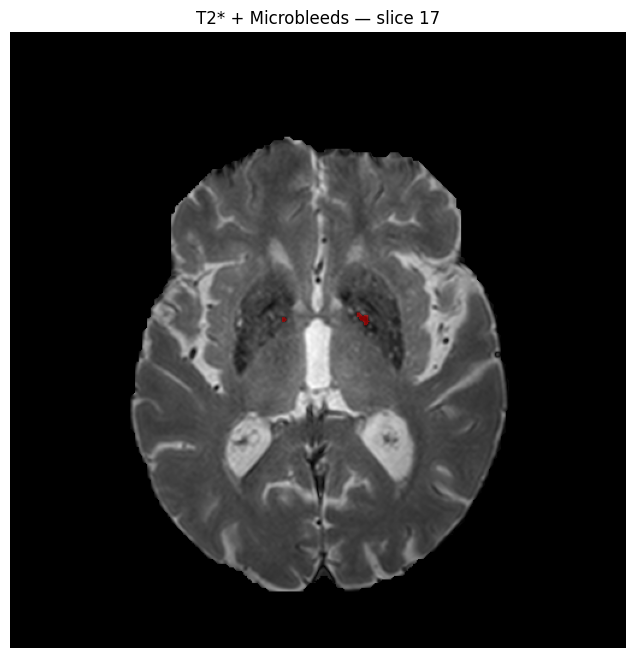

Procesando: sub-102 — Archivos cargados correctamente.


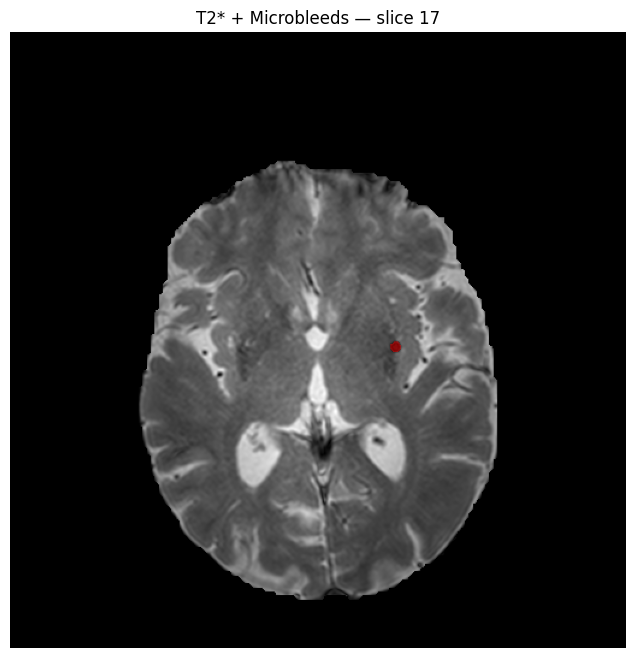

Procesando: sub-103 — Archivos cargados correctamente.


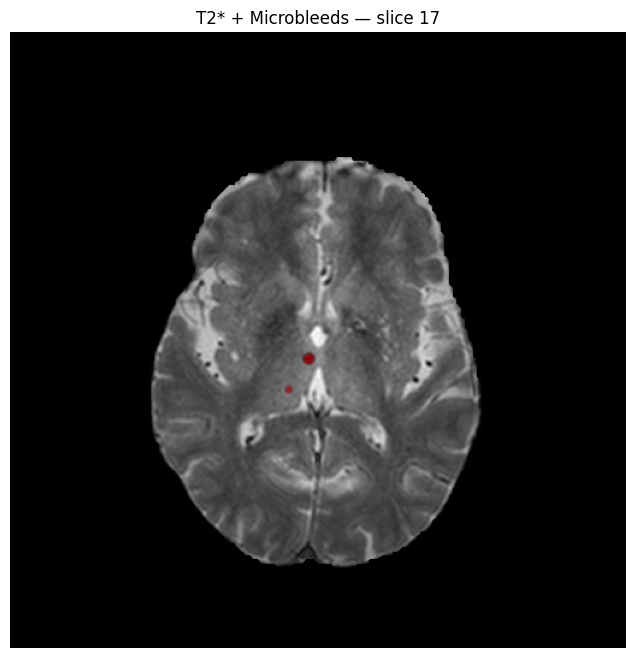

Procesando: sub-104 — Archivos cargados correctamente.


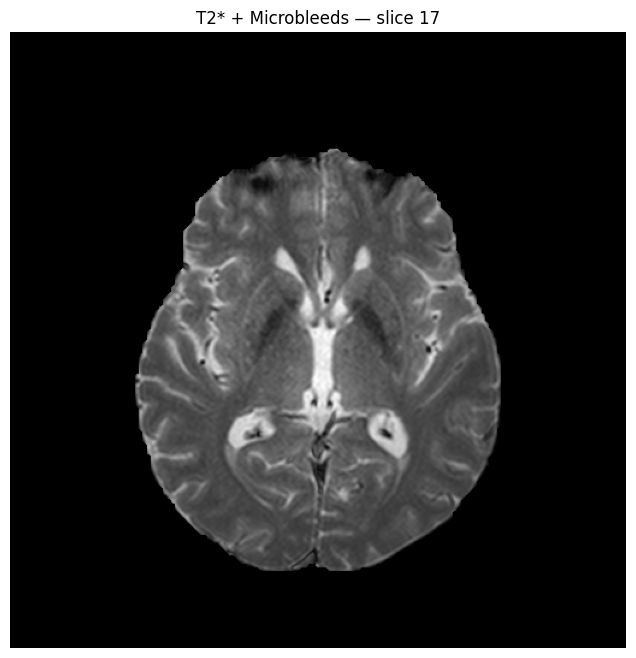

Procesando: sub-105 — Archivos cargados correctamente.


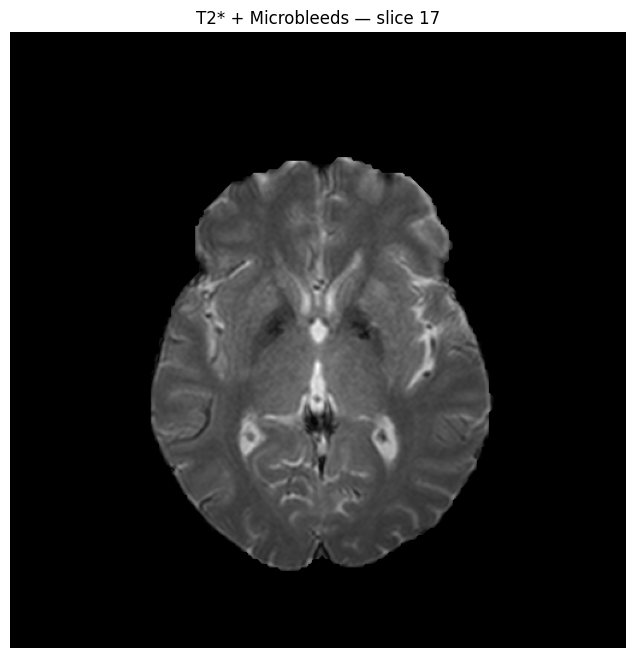

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Rutas nueva estructura nnU-Net
# -----------------------------
NNUNET_DIR = "/media/guest/PORT-DISK/Practicas/MicroBleeds/nnUNet_raw_data/TaskVALDO"
imagesTr_dir = os.path.join(NNUNET_DIR, "imagesTr")
labelsTr_dir = os.path.join(NNUNET_DIR, "labelsTr")

# -----------------------------
# Función para cargar NIfTI
# -----------------------------
def load_nifti(path):
    nii = nib.load(path)
    data = nii.get_fdata()
    return data, nii.affine

# -----------------------------
# Función para visualizar T2* + máscara CMB
# -----------------------------
def plot_t2s_with_cmb(t2s, cmb, slice_idx=None, alpha=0.5):
    if slice_idx is None:
        slice_idx = t2s.shape[2] // 2
    img = t2s[:, :, slice_idx]
    mask = cmb[:, :, slice_idx]

    plt.figure(figsize=(8, 8))
    plt.imshow(img.T, cmap="gray", origin="lower")
    plt.imshow(np.ma.masked_where(mask == 0, mask).T,
               cmap="autumn", alpha=alpha, origin="lower")
    plt.title(f"T2* + Microbleeds — slice {slice_idx}")
    plt.axis("off")
    plt.show()

# -----------------------------
# Listar sujetos a partir de imagesTr
# -----------------------------
files_t2s = sorted([f for f in os.listdir(imagesTr_dir) if f.endswith("_0000.nii.gz")])
sub_ids = [f.split("_")[0] for f in files_t2s]

# -----------------------------
# Recorrer solo los 5 primeros sujetos
# -----------------------------
for i, sub_id in enumerate(sub_ids):
    if i >= 5:
        break

    # Rutas de imágenes y máscaras en la nueva estructura
    fname_t2s = os.path.join(imagesTr_dir, f"{sub_id}_0000.nii.gz")  # T2*
    fname_cmb = os.path.join(labelsTr_dir, f"{sub_id}.nii.gz")       # máscara

    # Cargar imágenes
    t2s, _ = load_nifti(fname_t2s)
    cmb, _ = load_nifti(fname_cmb)

    print(f"Procesando: {sub_id} — Archivos cargados correctamente.")

    # Visualizar
    plot_t2s_with_cmb(t2s, cmb)


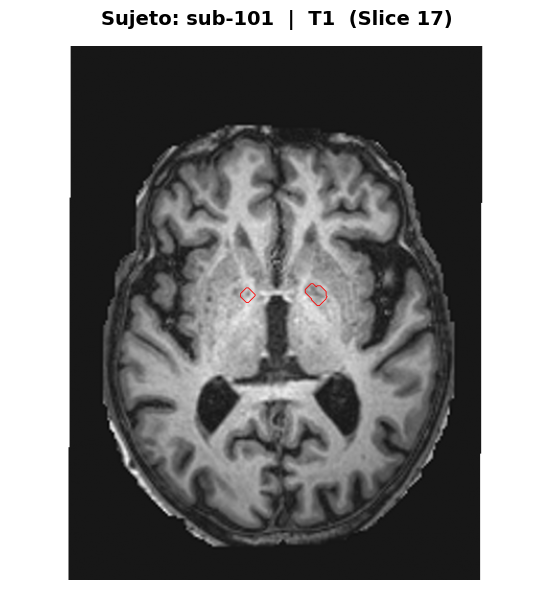

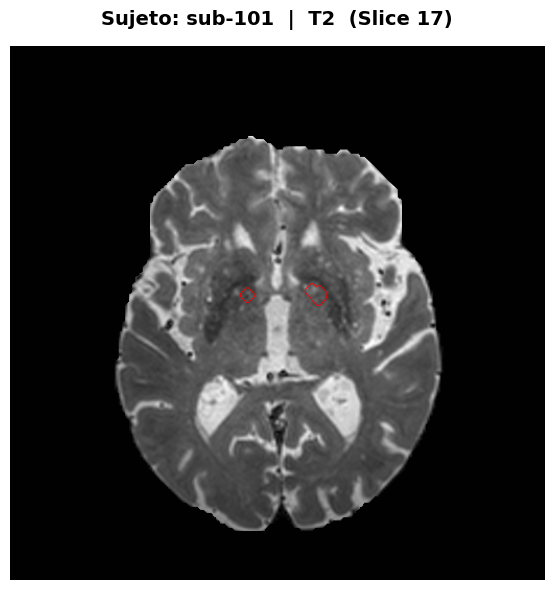

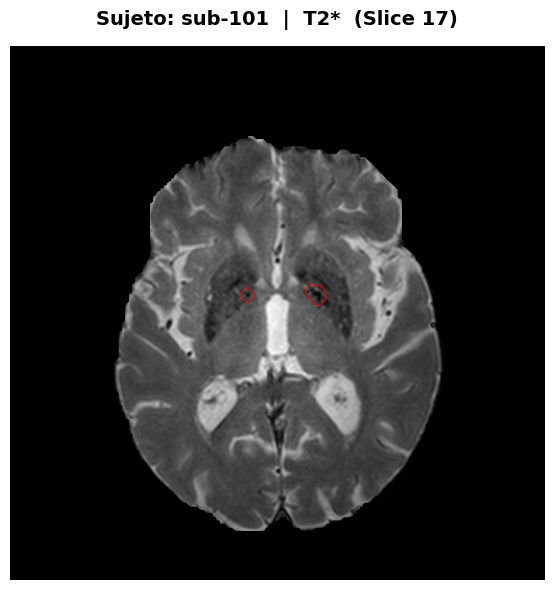

In [2]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

# -----------------------------
# CONFIGURACIÓN
# -----------------------------
NNUNET_DIR = "/media/guest/PORT-DISK/Practicas/MicroBleeds/nnUNet_raw_data/TaskVALDO"
imagesTr_dir = os.path.join(NNUNET_DIR, "imagesTr")
labelsTr_dir = os.path.join(NNUNET_DIR, "labelsTr")

SUFFIX_T2S = "_0000"
SUFFIX_T1  = "_0001"
SUFFIX_T2  = "_0002"

# --- AJUSTES VISUALES ---
LINE_WIDTH = 0.6      # Grosor del contorno (muy fino)
EXPANSION_PX = 5      # Píxeles de separación (radio de la "diana")
TITULO_PAD = 15       # Separación del título hacia arriba

# -----------------------------
# Funciones
# -----------------------------
def load_nifti(path):
    if not os.path.exists(path): return None
    return nib.load(path).get_fdata()

def resize_to_match(img, target_shape, order=3):
    """Iguala resoluciones para que T1 no se vea pequeño."""
    if img.shape == target_shape: return img
    factors = (target_shape[0]/img.shape[0], target_shape[1]/img.shape[1])
    return scipy.ndimage.zoom(img, factors, order=order)

def plot_individual_figures(t1, t2, t2s, mask, sub_id, slice_idx):
    
    # 1. Preparar datos (Transponer .T y obtener corte)
    s_t1 = t1[:, :, slice_idx].T
    s_t2 = t2[:, :, slice_idx].T
    s_t2s = t2s[:, :, slice_idx].T
    s_mask = mask[:, :, slice_idx].T

    # 2. Igualar tamaños usando T2* como base
    target_shape = s_t2s.shape
    s_t1 = resize_to_match(s_t1, target_shape, order=3)
    s_t2 = resize_to_match(s_t2, target_shape, order=3)
    s_mask = resize_to_match(s_mask, target_shape, order=0)

    # 3. Crear máscara expandida (Diana)
    # Se dilata la máscara para que el círculo rojo rodee la lesión sin tocarla
    mask_expanded = scipy.ndimage.binary_dilation(s_mask, iterations=EXPANSION_PX)

    # Lista de configuraciones para iterar
    # (Nombre Modalidad, Datos Imagen)
    plots = [
        ("T1", s_t1),
        ("T2", s_t2),
        ("T2*", s_t2s)
    ]

    # 4. Generar UNA figura distinta por cada modalidad
    for modality_name, img_data in plots:
        plt.figure(figsize=(6, 6)) # Cuadrado perfecto
        
        # Imagen de fondo
        plt.imshow(img_data, cmap="gray", origin="lower")
        
        # Contorno Rojo
        plt.contour(mask_expanded, levels=[0.5], colors='red', linewidths=LINE_WIDTH)
        
        # Título arriba y separado
        full_title = f"Sujeto: {sub_id}  |  {modality_name}  (Slice {slice_idx})"
        plt.title(full_title, fontsize=14, fontweight='bold', pad=TITULO_PAD)
        
        plt.axis("off")
        plt.tight_layout()
        plt.show() # Muestra y cierra la figura actual para empezar la siguiente

# -----------------------------
# Ejecución
# -----------------------------
files_t2s = sorted([f for f in os.listdir(imagesTr_dir) if f.endswith(f"{SUFFIX_T2S}.nii.gz")])
sub_ids = [f.split("_")[0] for f in files_t2s]

if sub_ids:
    # ELIGE AQUÍ EL SUJETO (0, 1, 2...)
    sub_id = sub_ids[0]
    
    p_t2s = os.path.join(imagesTr_dir, f"{sub_id}{SUFFIX_T2S}.nii.gz")
    p_t1  = os.path.join(imagesTr_dir, f"{sub_id}{SUFFIX_T1}.nii.gz")
    p_t2  = os.path.join(imagesTr_dir, f"{sub_id}{SUFFIX_T2}.nii.gz")
    p_lbl = os.path.join(labelsTr_dir, f"{sub_id}.nii.gz")

    d_t2s = load_nifti(p_t2s)
    d_t1  = load_nifti(p_t1)
    d_t2  = load_nifti(p_t2)
    d_lbl = load_nifti(p_lbl)

    if d_t2s is not None and d_t1 is not None and d_t2 is not None:
        if np.sum(d_lbl) > 0:
            # Buscar corte con más lesión
            slice_idx = np.argmax(np.sum(d_lbl, axis=(0, 1)))
            plot_individual_figures(d_t1, d_t2, d_t2s, d_lbl, sub_id, slice_idx)
        else:
            print(f"El sujeto {sub_id} no tiene lesiones marcadas en la máscara.")